# Create test and validation set

## Initialization

In [9]:
%matplotlib inline
import os, sys
#import modules
from utils import *
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.models import Model, load_model
from keras import backend as K

import os, json

from keras.layers import Input
from keras.optimizers import SGD, RMSprop, Adam
from enum import Enum
from keras.layers.core import Dense


DATA_HOME_DIR = '/srv/data/dogscats'
# DATA_HOME_DIR = '/home/ubuntu/blocks_classifier/data/dogscats' # on ec2

reload(K)
K.image_dim_ordering()

Using TensorFlow backend.


'tf'

In [10]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' #'/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/srv/data/dogscats


In [11]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=8
no_of_epochs=1

# Fine tuning

In [33]:
output_classes = ["cats", "dogs"]

base_model = VGG16(include_top=True, weights='imagenet') ## functional API
## replaces last dense layer with another dense layer of size the number of classes
x = base_model.layers[-2].output ## output is prior to last output
predictions = Dense(len(output_classes), activation='softmax', name = "predictions")(x)
ft_model = Model(input=base_model.input, output=predictions)
optimizer = Adam(lr=0.001) #SGD(lr=0.001)

## Freezes all but last layers
for layer in ft_model.layers:
    layer.trainable = False

## Make the last 2 dense layers trainable
for layer in ft_model.layers[-1:]:
    layer.trainable = True

ft_model.compile(optimizer=optimizer,
                loss='categorical_crossentropy', metrics=['accuracy'])


In [32]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=8
no_of_epochs=1

In [6]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [6]:
batches = get_batches(train_path, batch_size=batch_size)
val_batches = get_batches(valid_path, batch_size=batch_size*2)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
ft_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=no_of_epochs,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
16896/23000 [=====================>........] - ETA: 144s - loss: 0.0981 - acc: 0.9618

In [8]:
ft_model.save(path+'cats_dogs_ep_2.h5')

# Predict the output

In [12]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_array(fpath, filenames, titles=None):
    plots([image.load_img(fpath+f) for f in filenames], titles=titles)
    
#Number of images to view for each visualization task
n_view = 8

In [13]:
ft_model = load_model(path+'cats_dogs_ep_2.h5')

### Evaluate the model again

In [14]:
val_batches = get_batches(valid_path, batch_size=batch_size, shuffle=False, class_mode='categorical')

Found 2000 images belonging to 2 classes.


In [ ]:
metrics = ft_model.evaluate_generator(val_batches, val_batches.nb_sample)

### Predicting on the model

In [112]:
def model_evaluate(val_path):
        val_batches = get_batches(val_path, batch_size=batch_size, shuffle=False, class_mode='categorical')
        return ft_model.evaluate_generator(val_batches, val_batches.nb_sample)


In [23]:
def model_predict(image_path, batch_size = batch_size):
    p_batches = get_batches(image_path, batch_size=batch_size, shuffle=False, class_mode=None)
    pred = ft_model.predict_generator(p_batches,p_batches.nb_sample)
    return p_batches, pred
    
#test_batches = get_batches(test_path, batch_size=batch_size, shuffle=False, class_mode=None)
#val_batches = get_batches(valid_path, batch_size=batch_size, shuffle=False, class_mode=None)
#t_batches = get_batches(train_path, batch_size=batch_size, shuffle=False, class_mode=None)

In [28]:
val_batches, val_predict = model_predict(valid_path,batch_size)

Found 2000 images belonging to 2 classes.


array([[ 0.7162,  0.2838],
       [ 0.9819,  0.0181],
       [ 0.8856,  0.1144],
       ..., 
       [ 0.6625,  0.3375],
       [ 0.002 ,  0.998 ],
       [ 0.0916,  0.9084]], dtype=float32)

In [113]:
metrics = model_evaluate(valid_path)

Found 2000 images belonging to 2 classes.


In [114]:
metrics

[0.68696489739418032, 0.72850000000000004]

### Couple of cats examples

array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

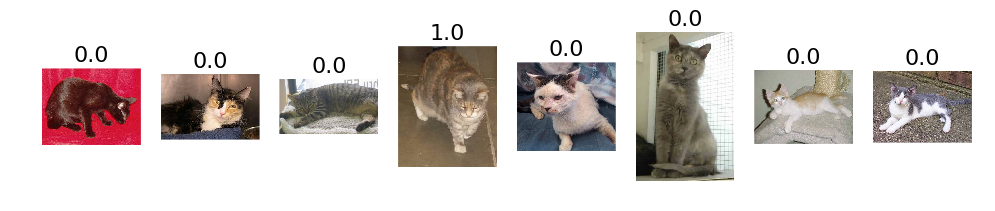

In [96]:
our_prediction = 1-val_predict[:,0]
our_class_prediction = np.round(our_prediction)
plots_array(valid_path, val_batches.filenames[:8], our_class_prediction[:8])
val_batches.classes[:8]

### Couple of dogs examples

array([1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

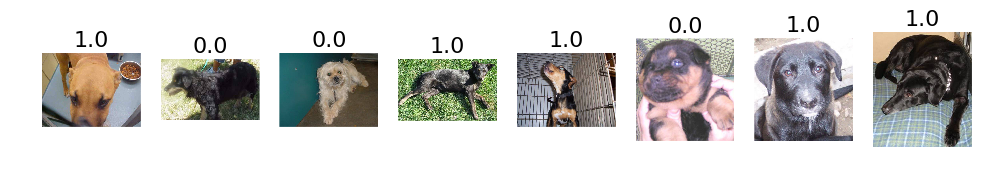

In [31]:
plots_array(valid_path, val_batches.filenames[-8:], our_class_prediction[-8:])
val_batches.classes[-8:]

### Most wrong cats

In [101]:
incorrect_cats = np.where((val_batches.classes == 0) & (our_class_prediction == 1))[0]

In [111]:
print "total incorrect cats: ", len(incorrect_cats), " which is %", 100*len(incorrect_cats)/len(np.where(val_batches.classes == 0)[0])

total incorrect cats:  216  which is % 21


In [102]:
idx_most_incorrect = np.argsort(our_prediction[incorrect_cats])[::-1][:n_view]

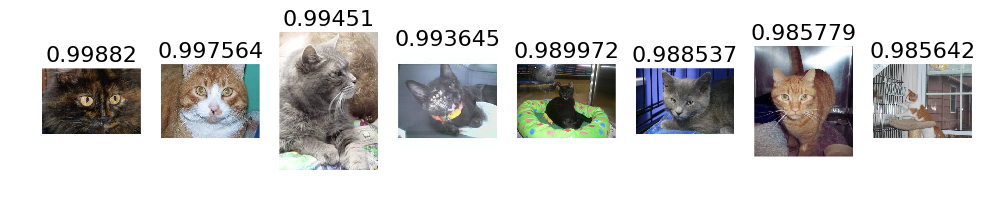

In [103]:
plots_array(valid_path, np.array(val_batches.filenames)[idx_most_incorrect], our_prediction[incorrect_cats][idx_most_incorrect])

### Borderline recognizing cats but seen as dogs

In [ ]:
idx_most_incorrect = np.argsort(our_prediction[incorrect_cats])[:n_view]
plots_array(valid_path, np.array(val_batches.filenames)[idx_most_incorrect], our_prediction[incorrect_cats][idx_most_incorrect])

### Most borderline false positives

In [ ]:
idx_most_incorrect = np.argsort(our_prediction[incorrect_cats])[::-1[:n_view]
plots_array(valid_path, val_batches.filenames[idx_most_incorrect], our_prediction[idx_most_incorrect])

### Most wrong dogs

In [13]:
#t_predict = np.round(1-t_predict[:,0])
val_predict = np.round(1-val_predict[:,0])
val_batches.classes[:1]
#t_predict[:]


array([ 0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.], dtype=float32)

In [30]:
print val_batches.classes[:8]
print v_predict[:]
print test_batches.classes[:8]
print test_predict[:]

[0 0 0 0 0 0 0 0]
[ 0.  0.  0.  0.  0.  0.  0.  0.]
[0 0 0 0 0 0 0 0]
[ 1.  0.  0.  1.  1.  0.  0.  1.]


In [ ]:
val_batches.classes[:,0]

In [15]:
test_predict = ft_model.predict_generator(test_batches,batch_size)

In [17]:
test_batches.filenames[:10]

['unknown/2957.jpg',
 'unknown/11706.jpg',
 'unknown/10629.jpg',
 'unknown/9810.jpg',
 'unknown/9834.jpg',
 'unknown/5308.jpg',
 'unknown/2850.jpg',
 'unknown/6998.jpg',
 'unknown/6901.jpg',
 'unknown/7008.jpg']

In [28]:
np.round(test_predict[:10,0])

array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.], dtype=float32)

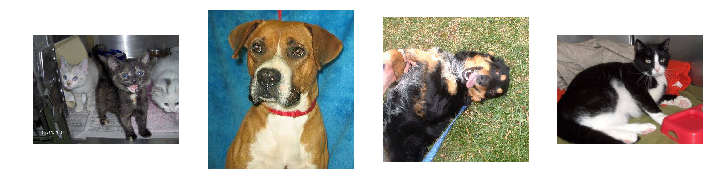

In [30]:
plots_array(test_path,test_batches.filenames[:4])

## Prep data

In [ ]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

# Prep data

In [10]:
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/srv/data/dogscats
mkdir: cannot create directory 'valid': File exists
mkdir: cannot create directory 'results': File exists


In [11]:
%cd $DATA_HOME_DIR/train


/srv/data/dogscats/train


In [12]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

In [13]:
from shutil import copyfile

In [14]:
g = glob("*.jpg")

In [19]:
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/' + shuf[i])

In [20]:
%cd $DATA_HOME_DIR/valid
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/' + shuf[i])

/srv/data/dogscats/valid


In [21]:
#Divide cat/dog images into separate directories

%cd $DATA_HOME_DIR/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/srv/data/dogscats/sample/train
/srv/data/dogscats/sample/valid
/srv/data/dogscats/valid
/srv/data/dogscats/train


In [22]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

/srv/data/dogscats/test
